# CS289A Project F

In [1]:
from collections import Counter
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd
import random
random.seed(246810)
np.random.seed(246810)
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
eps = 1e-5  # a small number
# Vectorized function for hashing for np efficiency
def w(x):
    return np.int(hash(x)) % 1000

h = np.vectorize(w)


## 1. Set up dataset

In [3]:
# some scripts to merge the SW time and HW time + features CSV files
# no need to run again !!

# path_chstone= '../data/baseline_chstone.csv'
# chstone = pd.read_csv(path_chstone, delimiter=',')

# path_random = '../data/baseline_random.csv'
# random = pd.read_csv(path_random, delimiter=',')
# random.sort_values(by = ['program'])

# random_sw=pd.read_csv('../data/sw_perf_random.csv', delimiter=',')
# chstone_sw=pd.read_csv('../data/sw_perf_chstone.csv', delimiter=',')

# merged_random = random.merge(random_sw, left_on='program', right_on='program')
# merged_chstone = chstone.merge(chstone_sw, left_on='program', right_on='program')

# merged_random.to_csv('../data/final_random.csv', index=False)
# merged_chstone.to_csv('../data/final_chstone.csv',index=False)


In [4]:
dataset = "csmith_random_programs"
data = pd.read_csv('final_random.csv', delimiter=',')

### Part (a). Pre-process the data


In [5]:
# set out training set to be 70% of total; 30% 
# random_idx = random.randint(0, np.shape(data)[0]) #27
num_train = round(np.shape(data)[0]*0.7)
train_data = data.values[0:num_train,:]
test_data =  data.values[num_train:, :]
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(data))

train_speedup = (train_data[:, -1] / train_data[:, 2]) # 
test_speedup = (test_data[:, -1] / test_data[:, 2]) # -O3
print(train_speedup)
# log_train_speedup = np.log10(train_speedup.astype(float))
# log_test_speedup = np.log10(test_speedup.astype(float))


(9011, 116)
(3862, 116)
(12873, 116)
[2915.27039334195 3064.5126890095776 3127.9902745113 ...
 2596.5991783791956 2804.3891404735623 3077.551395099053]


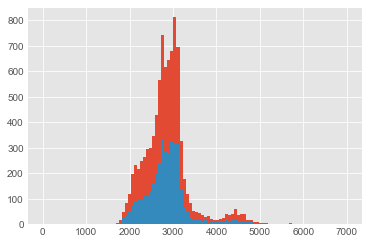

In [6]:
# EDA of speed up from training set
plt.style.use('seaborn-whitegrid')
plt.style.use('ggplot')
plt.hist(train_speedup, bins=100, range =(0, 7000))
plt.hist(test_speedup, bins=100, range = (0, 7000))

plt.show()


In [7]:
# Get binary preduction output: is speedup (HW vs SW) > 2800 
y = (train_speedup > 2800).astype(int)
X = train_data[:,-57:-1]
y_test = (test_speedup > 2800).astype(int)
X_test = test_data[:,-57:-1]
print(np.count_nonzero(y) / len(y))
print(np.count_nonzero(y_test) / len(y_test))
assert(len(y) == np.shape(train_data)[0])
assert(len(y_test) == np.shape(test_data)[0] )

features = data.columns.values[-57:-1]
assert len(features) == 56
class_names = ["On-Chip", "Not On-Chip"]


0.5433359227610698
0.5468669083376488


## Neural Net ##

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

In [111]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_test)
X_train.shape

(9011, 56)

In [112]:
#defining dataset class
from torch.utils.data import Dataset, DataLoader

class trainData(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length
    
class testData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

    
trainset = dtrainData(X_train,y)
test_data = testData(X_test)
train_loader = DataLoader(trainset,batch_size=64,shuffle=True)
test_loader = DataLoader(test_data,batch_size=1,shuffle=False)

In [113]:
class Net(nn.Module):
    def __init__(self,input_shape,width = 64, depth = 2):
        super(Net,self).__init__()
        self.width = width
        self.depth = depth
        self.layers = nn.ModuleList([])
        self.layers.append(nn.Linear(input_shape,self.width))
        for _ in range(1,self.depth-1):
            self.layers.append(nn.Linear(width,self.width))
        self.layers.append(nn.Linear(self.width,1))
        
    def forward(self,x):
        for i in range(0,self.depth-1):
            x = torch.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x

In [114]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [120]:
epochs = 500
lr_ = 0.001
# Model , Optimizer, Loss
model = Net(input_shape=X_train.shape[1],width = 32, depth = 4)
model.to(device)
print(model)
optimizer = torch.optim.SGD(model.parameters(),lr=lr_)
# Combines sigmoid and BCE in one class
loss_fn = nn.BCEWithLogitsLoss()

Net(
  (layers): ModuleList(
    (0): Linear(in_features=56, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [121]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [122]:
model.train()
for e in range(1, epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = loss_fn(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    if e%50 == 0:
        print(f'Epoch: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 050: | Loss: 0.61129 | Acc: 70.688
Epoch 100: | Loss: 0.53516 | Acc: 75.957
Epoch 150: | Loss: 0.52046 | Acc: 76.504
Epoch 200: | Loss: 0.51552 | Acc: 76.560
Epoch 250: | Loss: 0.51282 | Acc: 76.986
Epoch 300: | Loss: 0.51100 | Acc: 76.986
Epoch 350: | Loss: 0.50963 | Acc: 77.050
Epoch 400: | Loss: 0.50855 | Acc: 77.128
Epoch 450: | Loss: 0.50762 | Acc: 77.220
Epoch 500: | Loss: 0.50674 | Acc: 77.291


In [123]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [124]:
print(classification_report(y_test, y_pred_list))
print(accuracy_score(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.80      0.63      0.71      1750
           1       0.74      0.87      0.80      2112

    accuracy                           0.76      3862
   macro avg       0.77      0.75      0.76      3862
weighted avg       0.77      0.76      0.76      3862

0.7638529259451061


## Log Reg ##

In [11]:
# Scale data
clf = make_pipeline(StandardScaler(), LogisticRegression())
clf.get_params()
#Do grid search to optimize hyperparameters
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1], 'logisticregression__penalty': ['l2', 'l1']}
# Use default 5-fold CV
grid = GridSearchCV(clf,param_grid,refit=True,verbose=2, n_jobs = -1)
grid.fit(X,y)
print("Best params:")
print(grid.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    9.7s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.2s finished


Best params:
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [12]:
grid.score(X_test, y_test)

0.7628171931641636

## SVM ##

In [ ]:
clf = make_pipeline(StandardScaler(), SVC())
param_grid = {'svc__C': [0.01, 0.1, 1, 10], 'svc__gamma': [0.001, 0.1, 1], 'svc__kernel': ['rbf', 'linear']}
grid = GridSearchCV(clf,param_grid,refit=True,verbose = 1, n_jobs = 8, cv=3)
grid.fit(X,y)
print("Best params:")
print(grid.best_estimator_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   49.8s


In [ ]:
grid.score(X_test, y_test)

## Random Forest ##

In [24]:
# Scale data
clf = RandomForestClassifier()
#Do grid search to optimize hyperparameters
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10],
    'min_samples_leaf': [5, 10, 20],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [200, 300, 400]}
# Use default 5-fold CV
grid = GridSearchCV(clf,param_grid,refit=True,verbose = 1, n_jobs=-1)
grid.fit(X,y)
print("Best params:")
print(grid.best_estimator_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   55.8s finished


Best params:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [25]:
grid.score(X_test, y_test)

0.7705851890212325

In [26]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))#Output

[[1094  656]
 [ 230 1882]]
              precision    recall  f1-score   support

           0       0.83      0.63      0.71      1750
           1       0.74      0.89      0.81      2112

    accuracy                           0.77      3862
   macro avg       0.78      0.76      0.76      3862
weighted avg       0.78      0.77      0.77      3862



## AdaBoost ##

In [27]:
# Scale data
clf = AdaBoostClassifier()
#Do grid search to optimize hyperparameters
param_grid = {
    'learning_rate' : [0.001, 0.01, 0.1],
    'n_estimators': [200, 300, 400]}
# Use default 5-fold CV
grid = GridSearchCV(clf,param_grid,refit=True, verbose = 1, n_jobs=-1)
grid.fit(X,y)
print("Best params:")
print(grid.best_estimator_)

Best params:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=400, random_state=None)


In [28]:
grid.score(X_test, y_test)

0.7648886587260487

## Gradient Boosting Classifier ##

In [8]:
clf = GradientBoostingClassifier()
param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.001, 0.01],
    "min_samples_split": [2],
    "min_samples_leaf": [5],
    "max_depth":[5,10],
    "max_features":["sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.75, 1.0],
    "n_estimators":[100, 200]
    }

grid = GridSearchCV(clf,param_grid,refit=True, verbose = 1, n_jobs=12, cv = 3)
grid.fit(X, y)
print(grid.score(X_test, y_test))
print(grid.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   17.0s


KeyboardInterrupt: 

In [ ]:
grid.score(X_test, y_test)